<a href="https://colab.research.google.com/github/E-CG/AI4ENG/blob/master/03%20-%20Modelos-e-iteraciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **📦 Librerias y paquetes para la ejecución del notebook.**

In [ ]:
! pip install py7zr

In [ ]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle
# Aquí debes cambiar la dirección donde tengas tus credenciales de Kaggle
! cp /content/drive/MyDrive/Modelos_I/credentials_kaggle/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download favorita-grocery-sales-forecasting
! unzip favorita-grocery-sales-forecasting.zip

In [1]:
# Librerias uso básico
import numpy as np
import pandas as pd
import math as m
import time
import py7zr
import os
from subprocess import check_output

# Librerias preprocesado
from mlxtend.preprocessing import minmax_scaling
import datetime as dt

# Librerias para gráficar
import seaborn as sns
import matplotlib.pyplot as plt

# Funciones de sklearn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression,ElasticNet,Ridge,Lasso
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import learning_curve

## **🗂️Leyendo y extrayendo los archivos .csv**

In [7]:
# Ruta al archivo 7z en Google Drive
sevenzip_file_path = '/content'

# Directorio de destino para la extracción
extracted_dir = '/content/extracted_data/'

# Crear el directorio de destino si no existe
os.makedirs(extracted_dir, exist_ok=True)

# Listar los archivos .7z en el directorio de entrada
files_to_extract = [file for file in os.listdir(sevenzip_file_path) if file.endswith('.7z')]

# Iterar a través de los archivos y descomprimirlos
for file_to_extract in files_to_extract:
    with py7zr.SevenZipFile(os.path.join(sevenzip_file_path, file_to_extract), mode='r') as z:
        z.extractall(path=extracted_dir)

In [2]:
stores = pd.read_csv('/content/extracted_data/stores.csv')
items = pd.read_csv('/content/extracted_data/items.csv')
holidays_e = pd.read_csv('/content/extracted_data/holidays_events.csv', parse_dates=["date"])
transactions = pd.read_csv('/content/extracted_data/transactions.csv', parse_dates=["date"])
oil = pd.read_csv('/content/extracted_data/oil.csv', parse_dates=["date"])

# Cargar el archivo de entrenamiento en chunks
chunked_dfs = pd.read_csv("/content/extracted_data/train.csv",
                          chunksize=20000,
                          usecols=[0,1,2,3,4,5],
                          parse_dates=['date'],
                          low_memory=False)

print('Archivos cargados 🗞️✅')

Archivos cargados 🗞️✅


In [3]:
# Agrupar por estado y obtener el primer store_nbr en cada estado
tienda_por_estado = stores.groupby('state')['store_nbr'].first()
tienda_por_estado

state
Azuay                             37
Bolivar                           19
Chimborazo                        14
Cotopaxi                          12
El Oro                            40
Esmeraldas                        43
Guayas                            24
Imbabura                          15
Loja                              38
Los Rios                          31
Manabi                            52
Pastaza                           22
Pichincha                          1
Santa Elena                       25
Santo Domingo de los Tsachilas     5
Tungurahua                        23
Name: store_nbr, dtype: int64

In [4]:
# Inicializar una lista para almacenar los DataFrames filtrados
datos_filtrados = []

# Iterar a través de los chunks
for chunk in chunked_dfs:
    # Crear una máscara booleana para las tiendas seleccionadas
    mask_tiendas = chunk['store_nbr'].isin(stores['store_nbr'])
    # Crear una máscara booleana para las fechas entre 2016-01-01 a 2016-12-31
    mask_fechas = (chunk['date'] >= '2016-01-01') & (chunk['date'] <= '2016-12-31')
    # Aplicar ambas máscaras
    mask = mask_tiendas & mask_fechas

    # Aplicar la máscara y agregar las filas filtradas a la lista
    trozo_filtrado = chunk[mask]
    datos_filtrados.append(trozo_filtrado)

# Concatenar los DataFrames filtrados en uno solo
train_store_state = pd.concat(datos_filtrados, ignore_index=True)

In [11]:
train_store_state.head(3)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,66458908,2016-01-01,25,105574,12.0,False
1,66458909,2016-01-01,25,105575,9.0,False
2,66458910,2016-01-01,25,105857,3.0,False


In [5]:
# Seleccionar aleatoriamente 70.000 filas de 'train_store_state'
train_sample = train_store_state.sample(n=70000)

In [13]:
train_sample.head(3)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
31815211,98274119,2016-11-28,31,1458847,1.0,False
27505972,93964880,2016-10-15,39,1920284,1.0,False
2199601,68658509,2016-01-25,16,977007,2.0,False


## **📄Juntando los demás archivos en train.csv y generando dataframes de prueba y entrenamiento**

Haré uso de un pipeline utilizando dos clases, una para unir los demás archivos teniendo como base el dataframe de entrenamiento 'train_store_state'

In [6]:
class MergeDataTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Constructor de la clase
        print("Inicializando MergeDataTransformer")

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Unir DataFrames
        train_stores = X[0].merge(X[1], on='store_nbr')
        train_stores_oil = train_stores.merge(X[2], on='date')
        train_stores_oil_items = train_stores_oil.merge(X[3], on='item_nbr')
        train_stores_oil_items_transactions = train_stores_oil_items.merge(X[4], on=['date', 'store_nbr'])
        train_stores_oil_items_transactions_hol = train_stores_oil_items_transactions.merge(X[5], on='date')

        # Copiar DataFrame
        data = train_stores_oil_items_transactions_hol.copy(deep=True)

        # Cambiar booleanos a enteros
        data['onpromotion'] = data['onpromotion'].astype(int)
        data['transferred'] = data['transferred'].astype(int)

        # Cambiar nombres de columnas
        data.rename(columns={'type_x': 'st_type', 'type_y': 'hol_type'}, inplace=True)

        # Eliminar la columna 'id'
        data.drop(['id'], axis=1, inplace=True)

        # Mostrar las primeras filas del DataFrame resultante
        print(data.head())

        # Manipular la columna de fecha
        data['date'] = pd.to_datetime(data['date'])
        data['date'] = data['date'].map(dt.datetime.toordinal)

        return data

Divisor de Datos (SplitDataTransformer) ➗

Este transformador personalizado elimina la columna 'date' del conjunto de datos original y divide los datos en tres partes:

1. **Datos Numéricos (`data_numeric_df`):** Incluye todas las columnas numéricas del conjunto de datos original.

2. **Datos Categóricos (`data_categorical_df`):** Incluye todas las columnas categóricas del conjunto de datos original.

3. **Fecha (`data_date_df`):** Incluye la columna 'date' original.

In [7]:
class SplitDataTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Constructor de la clase
        print("Inicializando SplitDataTransformer")

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Eliminar la columna 'date' del DataFrame original
        df_without_date = X.drop(['date'], axis=1)

        # Obtener columnas numéricas y categóricas
        all_columns = df_without_date.columns
        numeric_columns = df_without_date._get_numeric_data().columns
        categorical_columns = list(set(all_columns) - set(numeric_columns))

        # Crear DataFrames separados para datos numéricos, categóricos y de fecha
        data_numeric_df = X[numeric_columns]
        data_categorical_df = X[categorical_columns]
        data_date_df = X['date']

        return data_numeric_df, data_categorical_df, data_date_df

Procesamiento de Datos (ProcessData) 🛤️

Este transformador personalizado realiza el procesamiento de datos, incluyendo:

1. **Datos Numéricos (`data_num_df`):**
   - Imputa valores nulos en atributos numéricos utilizando la estrategia de la media.
   - Aplica escalado estándar a los datos numéricos.

2. **Datos Categóricos (`data_cat_df`):**
   - Utiliza un codificador one-hot para representar las variables categóricas.
   - Convierte la representación codificada a un DataFrame.

3. **Fecha (`X[2]`):**
   - Mantiene la columna de fechas sin cambios.

In [8]:
class ProcessData(BaseEstimator, TransformerMixin):
    def __init__(self):
        print("Inicializando ProcessData")

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Datos numéricos
        # Imputar valores nulos en atributos numéricos
        imputer = SimpleImputer(strategy="mean", copy=True)
        num_imputed = imputer.fit_transform(X[0])
        data_num_df = pd.DataFrame(num_imputed, columns=X[0].columns, index=X[0].index)

        # Aplicar escalado estándar
        scaler = StandardScaler()
        num_scaled = scaler.fit_transform(data_num_df)
        data_num_df = pd.DataFrame(num_scaled, columns=X[0].columns, index=X[0].index)

        # Datos categóricos
        # One-hot encoder
        cat_encoder = OneHotEncoder(sparse=False)
        data_cat_1hot = cat_encoder.fit_transform(X[1])

        # Convertir a DataFrame con n*99, donde n es el número de filas y 99 es el número de categorías
        data_cat_df = pd.DataFrame(data_cat_1hot, columns=cat_encoder.get_feature_names_out(), index=X[1].index)

        return data_num_df, data_cat_df, X[2]

Unión de DataFrames (JoinDataFrames) 🖇️

Este transformador es útil para combinar información de diferentes conjuntos de datos antes de proceder con el análisis o modelado posterior.

In [9]:
class JoinDataFrames(BaseEstimator, TransformerMixin):
    def __init__(self):
        print("Inicializando JoinDataFrames")

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Unir DataFrames numéricos
        data_df = X[0].join(X[1])
        data_df = data_df.join(X[2])

        return data_df

Pipeline de Procesamiento de Datos 🔩

1. **Preparar Datos (`MergeDataTransformer`):**
   - Realiza las primeras manipulaciones de los datos.

2. **Dividir Datos (`SplitDataTransformer`):**
   - Separa los datos en categorías numéricas, categóricas y de fecha.

3. **Procesar Datos (`ProcessData`):**
   - Imputa valores nulos y aplica escalado a datos numéricos.
   - Codifica variables categóricas utilizando one-hot encoding.

4. **Unir Datos (`JoinDataFrames`):**
   - Combina DataFrames numéricos en uno solo.


In [10]:
# Definir la pipeline
pipeline = Pipeline([
    ('merge_data', MergeDataTransformer()),
    ('split_data', SplitDataTransformer()),
    ('process_data', ProcessData()),
    ('join_data', JoinDataFrames())
])

Inicializando MergeDataTransformer
Inicializando SplitDataTransformer
Inicializando ProcessData
Inicializando JoinDataFrames


Aplicar Pipeline y Dividir Datos ✅

In [11]:
# Aplicar la pipeline para transformar los datos
data_df = pipeline.fit_transform([train_sample, stores, oil, items, transactions, holidays_e])

# Dividir los datos según características
X = data_df.drop(['unit_sales', 'transactions'], axis=1)
Y = data_df[['unit_sales', 'transactions']]

        date  store_nbr  item_nbr  unit_sales  onpromotion       city  \
0 2016-08-24         26   1473482      15.313            1  Guayaquil   
1 2016-08-24         26   1239916       1.000            0  Guayaquil   
2 2016-08-24          9   1473413       2.833            0      Quito   
3 2016-08-24          9    457928      95.257            0      Quito   
4 2016-08-24          9   1695847       2.690            0      Quito   

       state st_type  cluster  dcoilwtico   family  class  perishable  \
0     Guayas       D       10       46.29  PRODUCE   2034           1   
1     Guayas       D       10       46.29    DAIRY   2172           1   
2  Pichincha       B        6       46.29  PRODUCE   2032           1   
3  Pichincha       B        6       46.29  POULTRY   2416           1   
4  Pichincha       B        6       46.29  PRODUCE   2006           1   

   transactions hol_type locale locale_name          description  transferred  
0           471  Holiday  Local      Ambat

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [12]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [58]:
y_train.head(8)

,unit_sales,transactions
7181,0.385960,-0.616539
9207,-0.129510,1.014860
3828,-0.276787,-0.021977
1168,-0.276787,0.002645
7261,-0.055871,-0.279134
9665,-0.203148,1.915822
10468,-0.166329,0.632771
5832,-0.276787,0.055535


## **🔎Utilizando algunos modelos para hacer las primeras predicciones**

Función que evalua el rendimiento utilizando los estadisticos (MAE, MSE) tanto para los datos de entrenamiento como para los de prueba

In [13]:
def checkModelPerformance(model):
    model.fit(x_train.values, y_train.values)

    pred = model.predict(x_test.values)

    print("Media cuadrada del error: ", np.sqrt(mean_squared_error(y_test.values, pred)))
    print("Media absoluta del error: ", np.sqrt(mean_absolute_error(y_test.values, pred)))

In [14]:
print("LinearRegression")
checkModelPerformance(LinearRegression())

LinearRegression
Media cuadrada del error:  0.7528564657267515
Media absoluta del error:  0.5746054216564518


In [15]:
print("Lasso")
checkModelPerformance(Lasso(alpha=0.1))

Lasso
Media cuadrada del error:  0.8476379479413259
Media absoluta del error:  0.6487380496425293


In [16]:
print("ElasticNet")
checkModelPerformance(ElasticNet())

ElasticNet
Media cuadrada del error:  0.987851350718762
Media absoluta del error:  0.744738021540117


In [17]:
print("Ridge")
checkModelPerformance(Ridge(alpha=1.0))

Ridge
Media cuadrada del error:  0.7526121915724839
Media absoluta del error:  0.5739975466212138


In [18]:
print("Random Forest")
checkModelPerformance(RandomForestRegressor(random_state=42))

Random Forest
Media cuadrada del error:  0.7835274912011149
Media absoluta del error:  0.4604285293037706


👀 Sé que en el anterior notebook el modelo que era mejor en este proyecto era ElasticNet pero con las mejoras aplicadas a los algoritmos lo es RandomForest que tiene la MAE menor.

## **🧾Metrica de evaluación**

Los pesos, $w_i$, se pueden encontrar en el archivo items.csv (consultar la página de Datos). Los artículos perecederos tienen un peso de 1.25, mientras que todos los demás artículos tienen un peso de 1.00.

Quiero utilizar la métrica de evaluación para saber cual es el rendimiento de los diferentes modelos que estoy probando.

In [19]:
def calculate_nwrmsle(y_true, y_pred, weights_dict):
    # y_pred es un 2D array quiero seleccionar la primera columna
    y_pred_log = np.log1p(y_pred[:, 0])

    # Aplicar logaritmo natural a los valores reales
    y_true_log = np.log1p(y_true)

    # Calcular el error cuadrático medio ponderado
    squared_errors = (y_true_log - y_pred_log) ** 2

    # Utilizar solo la columna de 'unit_sales' para weights_dict
    weighted_squared_errors = [squared_errors[i] * weights_dict[item_nbr] for i, item_nbr in enumerate(weights_dict)]

    # Calcular la métrica NWRMSLE
    nwrmsle = np.sqrt(np.sum(weighted_squared_errors) / len(y_true))

    return nwrmsle

In [20]:
# Lista de modelos
modelos = [
    LinearRegression(),
    Lasso(alpha=0.1),
    ElasticNet(),
    Ridge(alpha=1.0),
    RandomForestRegressor(random_state=42)
]

# Entrenar y evaluar cada modelo
for modelo in modelos:
    # Entrenar el modelo
    modelo.fit(x_train, y_train)

    # Hacer predicciones
    y_pred = modelo.predict(x_test.values)

    # Calcular NWRMSLE
    weights_dict = {item_nbr: 1.25 if perishable == 1 else 1.00 for item_nbr, perishable in zip(x_test['item_nbr'], x_test['perishable'])}
    nwrmsle = calculate_nwrmsle(y_test['unit_sales'].values, y_pred, weights_dict)

    # Imprimir nombre del modelo y NWRMSLE
    print(f"{type(modelo).__name__}: NWRMSLE = {nwrmsle}\n")

LinearRegression: NWRMSLE = 0.29608239772398565

Lasso: NWRMSLE = 0.2975505117630286



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


ElasticNet: NWRMSLE = 0.2973563431940193

Ridge: NWRMSLE = 0.2951184162604584

RandomForestRegressor: NWRMSLE = 0.2991190906077484



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


## **⚒️Refinando modelo**

### Optimización de Hiperparámetros con RandomForestRegressor ⚙️

En este código, se utiliza `RandomForestRegressor` junto con `GridSearchCV` para encontrar los mejores hiperparámetros para el modelo. `RandomForestRegressor` es un algoritmo que utiliza múltiples árboles de decisión para hacer predicciones.

La métrica utilizada para evaluar el rendimiento del modelo es el error cuadrático medio negativo (`neg_mean_squared_error`). La búsqueda en la cuadrícula se realiza mediante validación cruzada con 5 divisiones (`cv=5`).

In [21]:
# Crear un RandomForestRegressor con un estado aleatorio fijo para reproducibilidad
forest_reg = RandomForestRegressor(random_state=42)

# Definir los parámetros que deseas probar
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},  # Primer conjunto de hiperparámetros
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},  # Segundo conjunto de hiperparámetros
]

# Crear un objeto GridSearchCV
grid_search = GridSearchCV(
    forest_reg,  # El modelo a utilizar
    param_grid,  # La cuadrícula de parámetros a probar
    cv=5,  # Número de divisiones en la validación cruzada (k-fold)
    scoring='neg_mean_squared_error',  # Métrica a optimizar
    return_train_score=True  # Devolver puntajes de entrenamiento además de puntajes de prueba
)

# Entrenar el modelo con todas las combinaciones de hiperparámetros
grid_search.fit(x_train.values, y_train.values)

# Mostrar los resultados del GridSearchCV
print(grid_search)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')


In [22]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [23]:
best_model = grid_search.best_estimator_

La búsqueda en la cuadrícula (`GridSearchCV`) se realiza sobre dos conjuntos de hiperparámetros diferentes. En el primer conjunto, se exploran combinaciones de `n_estimators` (número de árboles) y `max_features` (número máximo de características consideradas para dividir un nodo). En el segundo conjunto, se prueba desactivar el muestreo de bootstrap (`bootstrap: [False]`) junto con diferentes valores de `n_estimators` y `max_features`.


## **Curva de aprendizaje ➰**

Esta función grafica la curva de aprendizaje de un estimador.

Parametros:
  - estimator: El modelo a evaluar
  - title: Título del gráfico
  - X: Datos de entrenamiento
  - y: Etiquetas de entrenamiento
  - ylim: Rango del eje y (opcional)
  - cv: Número de divisiones en la validación cruzada (k-fold)
  - n_jobs: Número de trabajadores para paralelizar el cálculo (opcional)
  - train_sizes: Tamaños relativos del conjunto de entrenamiento (opcional)

In [ ]:
# Función para graficar la curva de aprendizaje
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    # Obtener puntajes de la curva de aprendizaje
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_squared_error')

    # Calcular medias y desviaciones estándar de los puntajes
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    # Rellenar áreas entre las medias y desviaciones estándar
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")

    # Graficar puntajes medios
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Graficar la curva de aprendizaje
plot_learning_curve(best_model, "Learning Curve", x_train.values, y_train['unit_sales'].values.ravel(), cv=5)
plt.show()

## **Iteraciones con el modelo ➰**

se realiza una transformación en los datos de la tienda (`stores`) y en las festividades (`holidays_e`). En `stores`, la ciudad se codifica como 1 si es 'Guayaquil' o 'Quito', y como 0 para otras ciudades. Además, se eliminan las columnas 'state', 'type' y 'cluster'. En `holidays_e`, se eliminan las columnas 'locale_name', 'description' y 'transferred'.


In [24]:
stores.city = stores.city.apply(lambda x: 1 if (x == 'Guayaquil' or x == 'Quito') else 0)
stores.drop(columns=['state', 'type', 'cluster'], inplace= True)

holidays_e.drop(columns = ['locale_name', 'description', 'transferred'], inplace = True)

Este transformador fusiona los datos de entrada (`X`) con información de tiendas, precios del petróleo y festividades.


In [25]:
# Definición de una clase personalizada para fusionar datos
class MergeData(BaseEstimator, TransformerMixin):
    def __init__(self):
        print("MergeData para predicciones")

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Fusionar datos con tiendas, petróleo y festividades
        pre_data = pd.merge(pd.merge(pd.merge(X, stores, on='store_nbr', how='left'), oil, on='date', how='left'), holidays_e, on='date', how='left')

        # Ordenar los datos por fecha
        pre_data = pre_data.sort_values('date')

        # Manejar valores nulos en la columna 'dcoilwtico' utilizando un método de retroceso (backfill)
        pre_data.dcoilwtico = pre_data.dcoilwtico.fillna(method='bfill', axis=0).fillna(0)

        # Rellenar valores nulos en las columnas 'type' y 'locale' con 'Normal'
        pre_data.type = pre_data.type.fillna('Normal')
        pre_data.locale = pre_data.locale.fillna('Normal')

        # Codificación one-hot de variables categóricas
        encoder = OneHotEncoder()
        categorical_cols = ['store_nbr', 'item_nbr', 'onpromotion', 'city', 'type', 'locale']
        encoder.fit(pre_data[categorical_cols])
        encoded_cols = encoder.transform(pre_data[categorical_cols]).toarray()
        encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(categorical_cols))

        # Concatenar las columnas codificadas con el DataFrame original
        pre_data = pd.concat([pre_data.drop(columns=categorical_cols), encoded_df], axis=1)

        # Restablecer el índice y eliminar la columna de índice adicional
        data = pre_data.reset_index().drop(columns='index')

        return data

Divide los datos de entrada (`X`) en conjuntos de entrenamiento y prueba, extrayendo la columna 'unit_sales' como la variable objetivo.

In [26]:
# Definición de una clase personalizada para dividir datos
class SplitData(BaseEstimator, TransformerMixin):
    def __init__(self):
        print("SplitData para predicciones")

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Extraer la columna 'unit_sales' como variable objetivo
        y = X.pop('unit_sales')

        # Separar los datos en conjuntos de entrenamiento y prueba
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

        # Establecer la columna 'date' como índice en los conjuntos de entrenamiento y prueba
        X_train = X_train.set_index('date')
        X_test = X_test.set_index('date')

        return X_train, X_test, y_train, y_test

In [27]:
pipeline_pred = Pipeline([
    ('merge_data', MergeData()),
    ('split_data', SplitData())
])

MergeData para predicciones
SplitData para predicciones


Para cada producto, intenta aplicar una pipeline (`pipeline_prueba`) para transformar los datos y luego entrena un modelo `RandomForestRegressor` (`forest_reg`).

**NOTA💥: Esta celda es la que más tarda, ya que genera las predicciones.**
🕰️Tiempo aproximado: 15-18 minutos

In [ ]:
productos = train_sample['item_nbr'].unique()
# Lista para almacenar los resultados
lista = list()

# Iterar sobre los productos
for i in productos:
    try:
        # Aplicar la pipeline para transformar los datos
        X_train, X_test, y_train, y_test = pipeline_pred.fit_transform(train_sample[train_sample.item_nbr == i])

        # Entrenar el modelo RandomForestRegressor
        forest_reg.fit(X_train.values, y_train.values)

        # Realizar predicciones en el conjunto de entrenamiento
        prediction = forest_reg.predict(X_train)

        # Almacenar los resultados en la lista
        lista.append([i, prediction[0]])

    except Exception as e:
        # En caso de error, almacenar 0.0 como resultado
        lista.append([i, 0.0])

Mostrando las predicciones

In [29]:
result = pd.DataFrame(lista, columns=['id', 'unit_sales'])
# Ordenar el DataFrame por la columna 'unit_sales' de forma descendente
result = result.sort_values('unit_sales', ascending=False)

result

,id,unit_sales
3618,1463864,234.68000
1464,1695835,183.14000
3380,2006812,162.74000
1457,208530,153.28958
3637,1402032,117.22000
...,...,...
3265,514445,0.00000
3664,1456886,0.00000
3501,1352754,0.00000
3762,1455272,0.00000


Se han generado **3763** predicciones para cada uno de los items, mostrando la cantidad estimada de unidades que se venderán. Es decir, para cada id (item), se ha estimado la cantidad de compra necesaria para satisfacer la demanda de cada una de las tiendas.

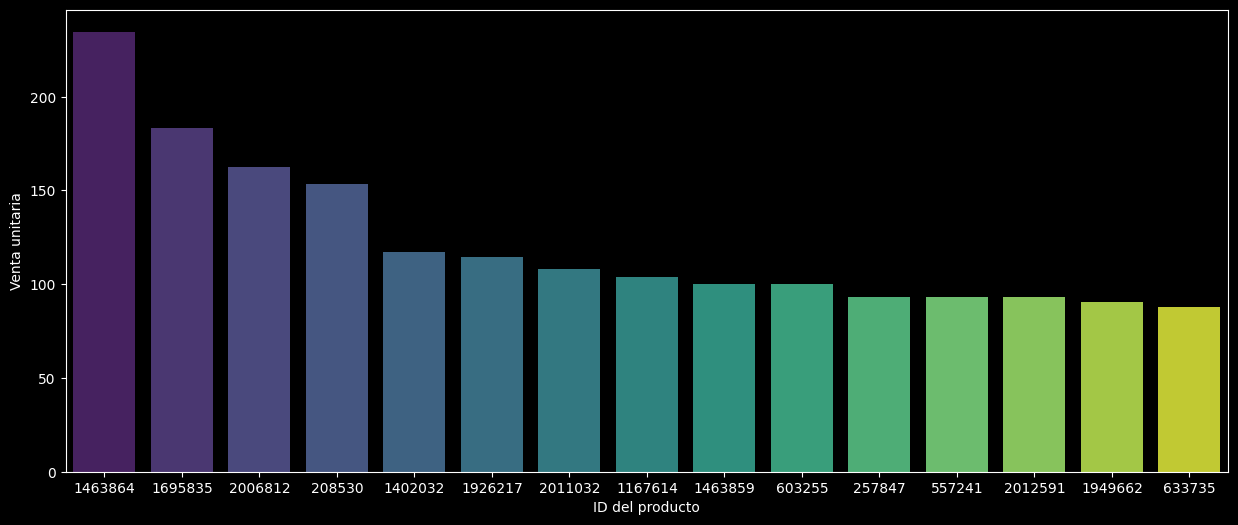

In [44]:
plt.style.use('dark_background')

# Ordenar el DataFrame por la columna 'unit_sales' de forma descendente
df_sorted = result.sort_values('unit_sales', ascending=False)

# Seleccionar los 15 valores más grandes
top_10 = df_sorted.nlargest(15, 'unit_sales')

plt.figure(figsize=(15, 6))
sns.barplot(data=top_10, x='id', y='unit_sales', order=top_10['id'], palette="viridis")

# Configurar los títulos de los ejes
plt.xlabel('ID del producto')
plt.ylabel('Venta unitaria')

# Mostrar el gráfico
plt.show()

Vemos que en un caso particular el item 1093340 es el que menos se debe comprar para posteriormente venderlo y en contra parte 1463864 es el producto más demandado para su venta.